# Chronos - Basic Usage

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [2]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
my_ts_data.shape

(2905, 2)

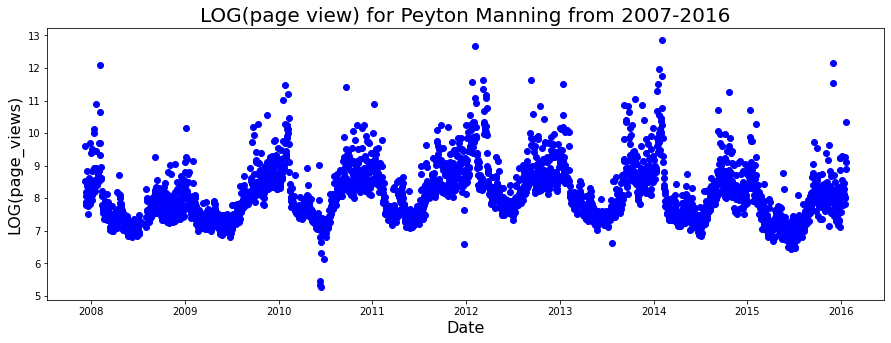

In [4]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

In [5]:
from chronos import Chronos

In [6]:
my_chronos = Chronos(method="MAP", 
                     max_iter=1000, 
                     learning_rate=0.1,
                     distribution="StudentT", 
                     seasonality_mode="mul")
my_chronos.fit(my_ts_data)

Employing Maximum A Posteriori
100.0% - ELBO loss: -1.9508                                                                         


In [7]:
future_df = my_chronos.make_future_dataframe(period=365)
future_df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
3265,2017-01-15,NaN
3266,2017-01-16,NaN
3267,2017-01-17,NaN
3268,2017-01-18,NaN


In [8]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

,ds,y,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower
0,2007-12-10,9.590761,8.384407,9.425411,7.437685,7.700676,7.700667,7.700667
1,2007-12-11,8.519590,8.309117,9.276471,7.325740,7.700676,7.700659,7.700659
2,2007-12-12,8.183677,8.201097,9.405140,7.160336,7.700674,7.700650,7.700650
3,2007-12-13,8.072467,8.107217,9.163120,7.173454,7.700673,7.700641,7.700641
4,2007-12-14,7.893572,8.126321,9.193295,7.000460,7.700672,7.700633,7.700633


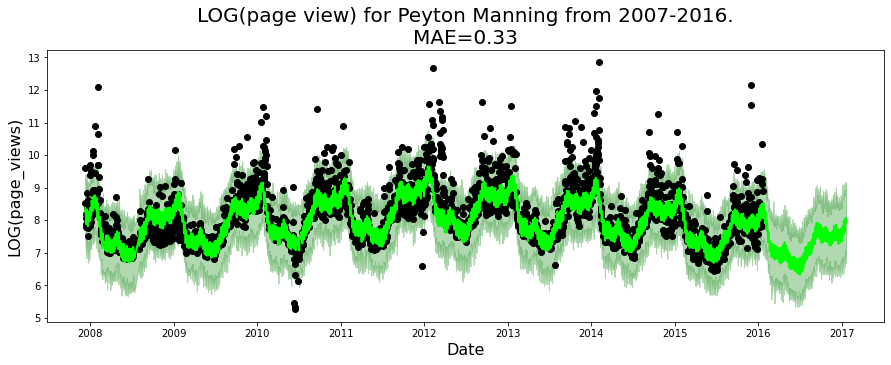

In [9]:
MAE = round(np.mean(np.abs(future_df['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c=(0.0, 1.0, 0.0), linewidth=2)
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("LOG(page_views)", size=16)
plt.title(f"LOG(page view) for Peyton Manning from 2007-2016.\nMAE={MAE}", size=20)
plt.savefig("Time Series v1 t-distribution.png", dpi=96*4)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


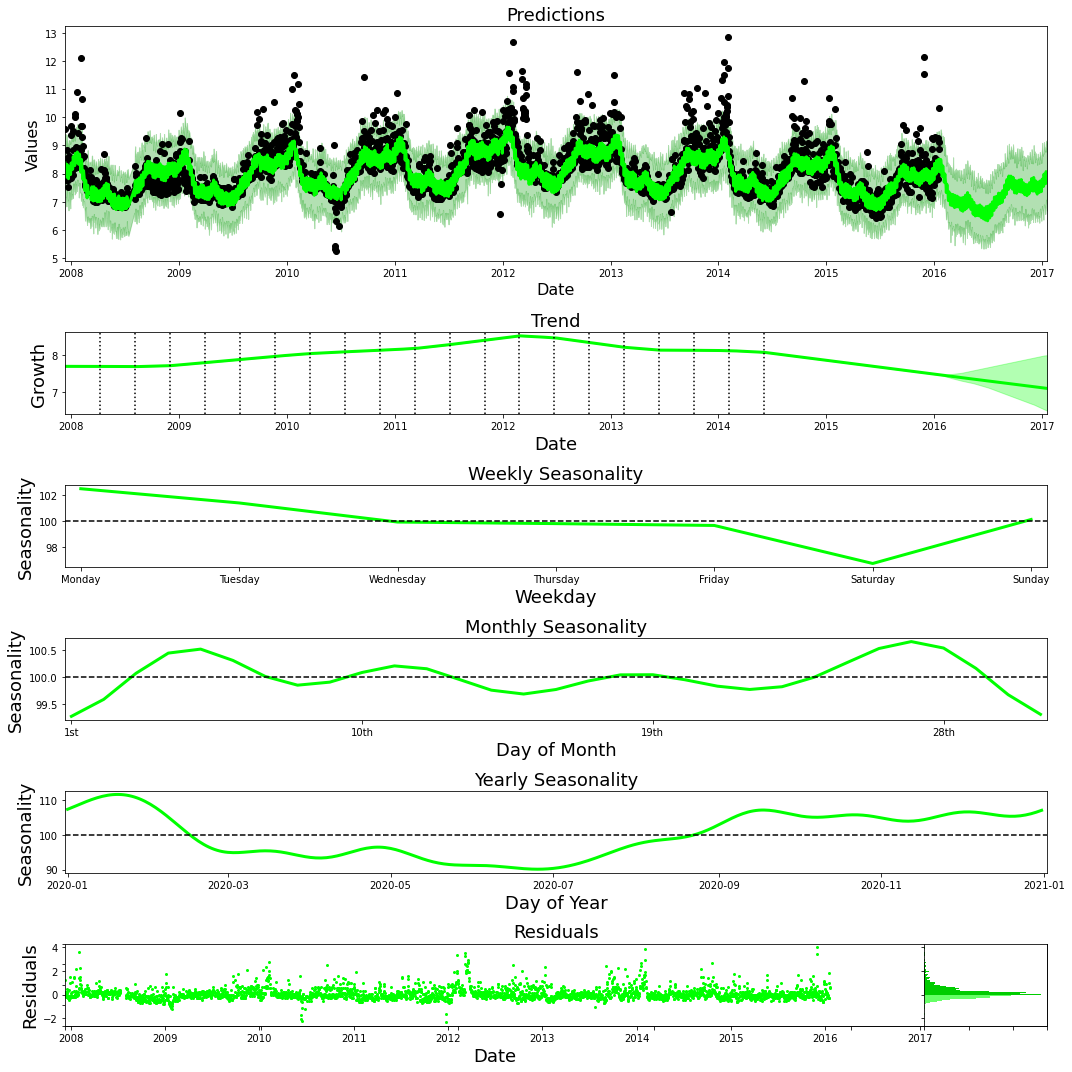

In [10]:
my_chronos.plot_components(predictions);

## COVID

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [12]:
covid_data = pd.read_csv('data/covid19-download.csv')
covid_data.head(2)

,pruid,prname,prnameFR,date,numconf,numprob,numdeaths,numtotal,numtested,numrecover,...,numdeaths_last14,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
0,35,Ontario,Ontario,2020-01-31,3,0,0.0,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,British Columbia,Colombie-Britannique,2020-01-31,1,0,0.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
canada_mask = covid_data['prname'] == 'Canada'
desired_columns = ['date', 'numtoday']

canada_daily_covid = covid_data[desired_columns].loc[canada_mask]
canada_daily_covid.head()

,date,numtoday
2,2020-01-31,4
5,2020-02-08,3
8,2020-02-16,1
11,2020-02-21,1
14,2020-02-24,1


In [14]:
canada_daily_covid.rename({'date': 'ds', 'numtoday': 'y'}, axis=1, inplace=True)
canada_daily_covid['ds'] = pd.to_datetime(canada_daily_covid['ds'])
#canada_daily_covid['y'] /= canada_daily_covid['y'].max()
canada_daily_covid.head()


,ds,y
2,2020-01-31,4
5,2020-02-08,3
8,2020-02-16,1
11,2020-02-21,1
14,2020-02-24,1


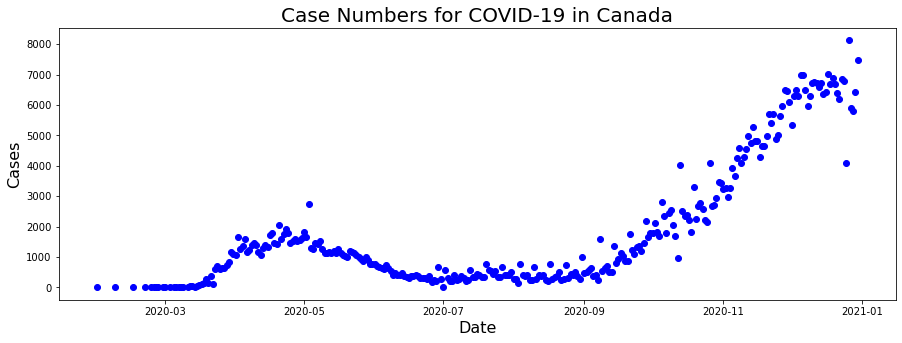

In [15]:
plt.figure(figsize=(15,5))
plt.scatter(canada_daily_covid['ds'], canada_daily_covid['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Cases", size=16)
plt.title(f"Case Numbers for COVID-19 in Canada", size=20)
plt.show()

In [16]:
my_chronos = Chronos(method="MLE", max_iter=2000, 
                     learning_rate=0.0001, 
                     n_changepoints=25,
                     changepoint_range=0.95,
                     changepoint_prior=0.1,
                     distribution="StudentT",
                     seasonality_mode="mul",
                     year_seasonality_order=0,
                     month_seasonality_order=0)#, weekly_seasonality_order=0, month_seasonality_order=0)
my_chronos.fit(canada_daily_covid)

Employing Maximum Likelihood Estimation
100.0% - ELBO loss: -2.0244                                                                         


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


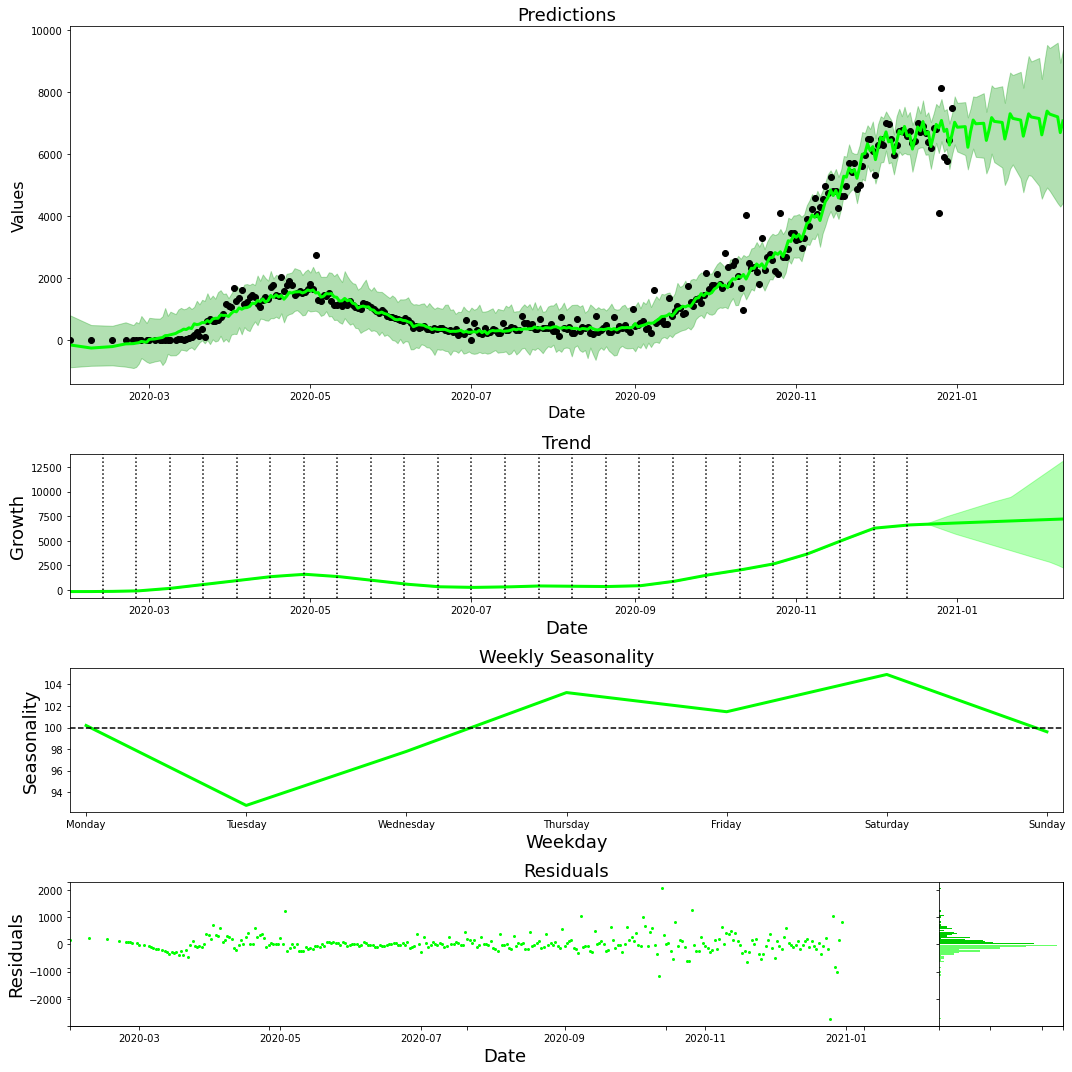

In [17]:
predictions = my_chronos.predict(sample_number=1000, frequency='B')
my_chronos.plot_components(predictions, changepoint_threshold=0.0, figure_name="COVID components.png");

In [18]:
my_chronos.changepoints_values

tensor([ 1.6401e-01,  6.8750e-01,  4.0711e-01,  1.3332e-02, -6.2984e-03,
        -5.0840e-01, -1.5268e+00, -4.8734e-01,  1.1931e-03,  3.4778e-01,
         6.8106e-01,  3.5493e-01,  1.8144e-01, -4.0307e-01, -4.1539e-02,
         3.6506e-01,  1.1717e+00,  6.7888e-01, -4.0072e-01,  3.0608e-01,
         1.2425e+00,  1.0872e+00, -1.7397e-01, -3.1192e+00, -5.6723e-01],
       requires_grad=True)

In [19]:
my_chronos.coef_

[tensor(-0.0193, requires_grad=True), tensor(0.0185, requires_grad=True)]

In [20]:
future_df = my_chronos.make_future_dataframe(period=62, frequency='D')
future_df

,ds,y
0,2020-01-31,4.0
1,2020-02-08,3.0
2,2020-02-16,1.0
3,2020-02-21,1.0
4,2020-02-24,1.0
...,...,...
368,2021-02-26,NaN
369,2021-02-27,NaN
370,2021-02-28,NaN
371,2021-03-01,NaN


In [21]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

,ds,y,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower
0,2020-01-31,4.0,-167.787598,388.847107,-849.284851,-157.251633,-157.253479,-157.253479
1,2020-02-08,3.0,-92.061653,492.472198,-909.913269,-153.651611,-153.650284,-153.650284
2,2020-02-16,1.0,-123.521835,449.655853,-756.044800,-136.843872,-136.842178,-136.842178
3,2020-02-21,1.0,-110.395798,665.964417,-870.954407,-114.632820,-114.631149,-114.631149
4,2020-02-24,1.0,-109.876961,595.986084,-916.602295,-101.303329,-101.304527,-101.304527


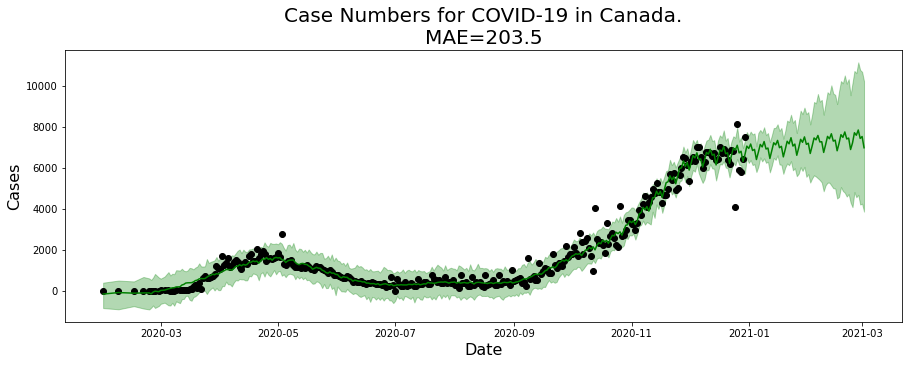

In [22]:
MAE = round(np.mean(np.abs(predictions['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(predictions['ds'], predictions['yhat'], c="green")
plt.fill_between(predictions['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(predictions['ds'], predictions['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("Cases", size=16)
plt.title(f"Case Numbers for COVID-19 in Canada.\nMAE={MAE}", size=20)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


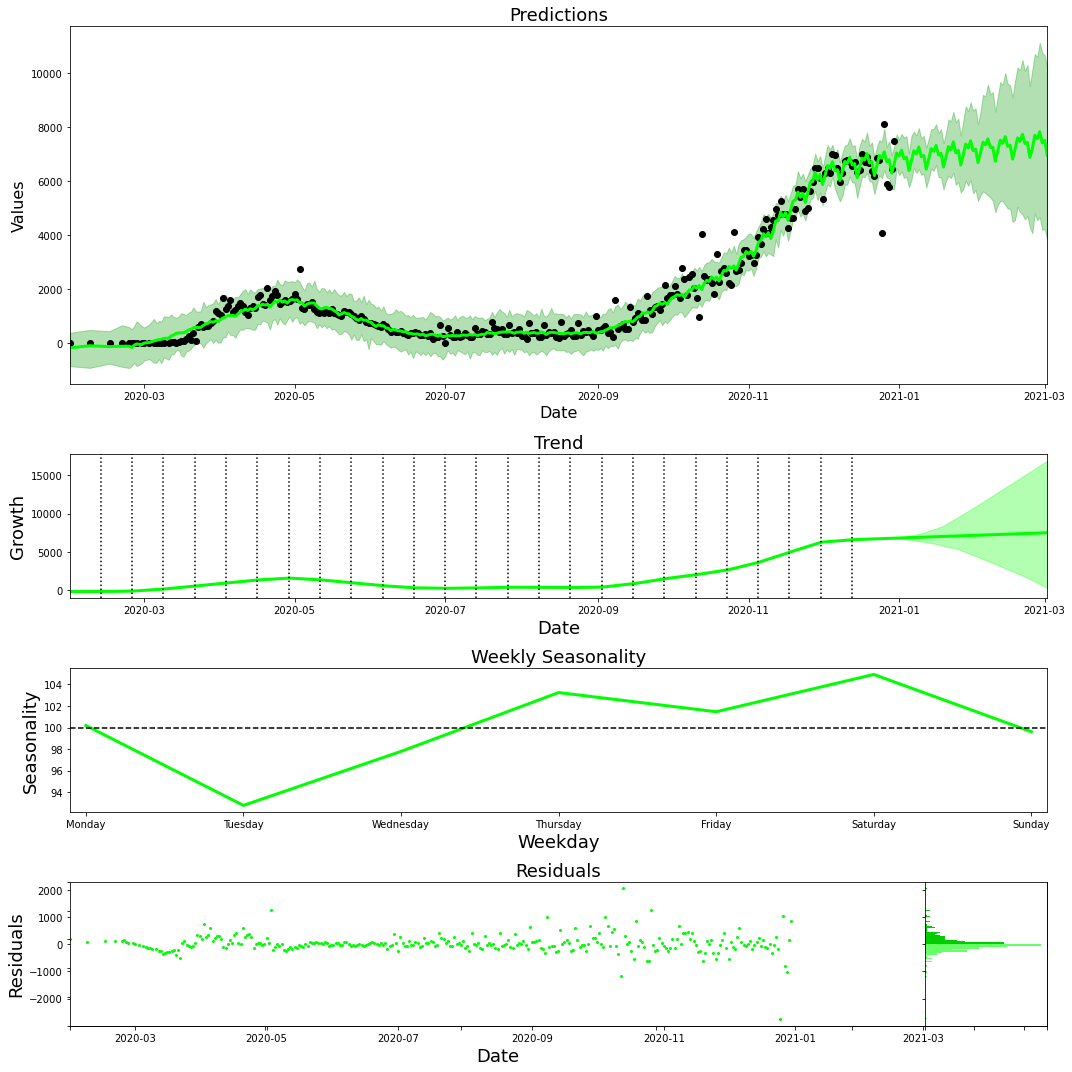

In [23]:
my_chronos.plot_components(predictions, changepoint_threshold=0.0, figure_name="COVID components.png");

## AAPL stocks

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from chronos import Chronos

In [25]:
my_ts_data = pd.read_csv('data/AAPL.csv')
my_ts_data = my_ts_data[['Date', 'Adj Close']]
my_ts_data.columns = ['ds', 'y']
#my_ts_data['y'] = 100*my_ts_data['y'].pct_change()
my_ts_data.dropna(inplace=True)
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561


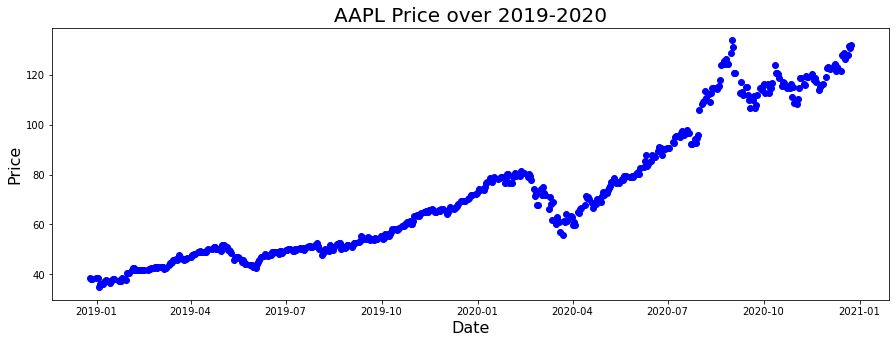

In [26]:
plt.figure(figsize=(15,5))
plt.scatter(my_ts_data['ds'], my_ts_data['y'], c="blue")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020", size=20)
plt.show()

In [27]:
my_ts_data['ds'].dt.day_name().isin(["Sunday", "Saturday"]).any()

False

In [28]:
my_chronos = Chronos(method="MLE", max_iter=1000, 
                     learning_rate=0.1, 
                     n_changepoints=25,
                     seasonality_mode="mul",
                     distribution="StudentT",
                     year_seasonality_order=0)
my_chronos.fit(my_ts_data)

Employing Maximum Likelihood Estimation
100.0% - ELBO loss: -2.2778                                                                         


In [29]:
future_df = my_chronos.make_future_dataframe(period=62, frequency='B')
future_df

,ds,y
0,2018-12-26,38.379425
1,2018-12-27,38.130344
2,2018-12-28,38.149883
3,2018-12-31,38.518612
4,2019-01-02,38.562561
...,...,...
562,2021-03-16,NaN
563,2021-03-17,NaN
564,2021-03-18,NaN
565,2021-03-19,NaN


In [30]:
predictions = my_chronos.predict(future_df, sample_number=1000)
predictions.head()

,ds,y,yhat,yhat_upper,yhat_lower,trend,trend_upper,trend_lower
0,2018-12-26,38.379425,38.401642,46.292442,29.824532,38.846756,38.847198,38.847198
1,2018-12-27,38.130344,38.346245,45.500122,30.823185,38.889492,38.889301,38.889301
2,2018-12-28,38.149883,38.464066,47.049423,30.502312,38.931801,38.931408,38.931408
3,2018-12-31,38.518612,38.691196,46.062737,30.579626,39.057526,39.057716,39.057716
4,2019-01-02,38.562561,39.284920,48.367905,29.801031,39.142021,39.141922,39.141922


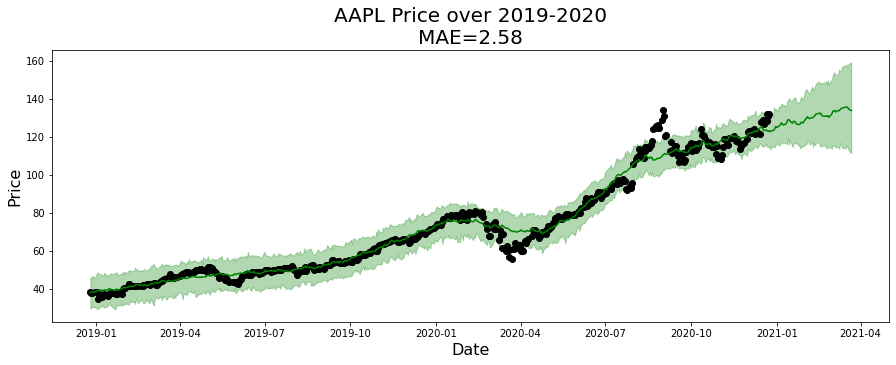

In [31]:
MAE = round(np.mean(np.abs(future_df['y'] - predictions['yhat'])), 2)

plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], predictions['yhat'], c="green")
plt.fill_between(future_df['ds'], predictions['yhat_upper'], predictions['yhat_lower'], color="green", alpha=0.3)
plt.scatter(future_df['ds'], future_df['y'], c="black")
plt.xlabel("Date", size=16)
plt.ylabel("Price", size=16)
plt.title(f"AAPL Price over 2019-2020\nMAE={MAE}", size=20)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


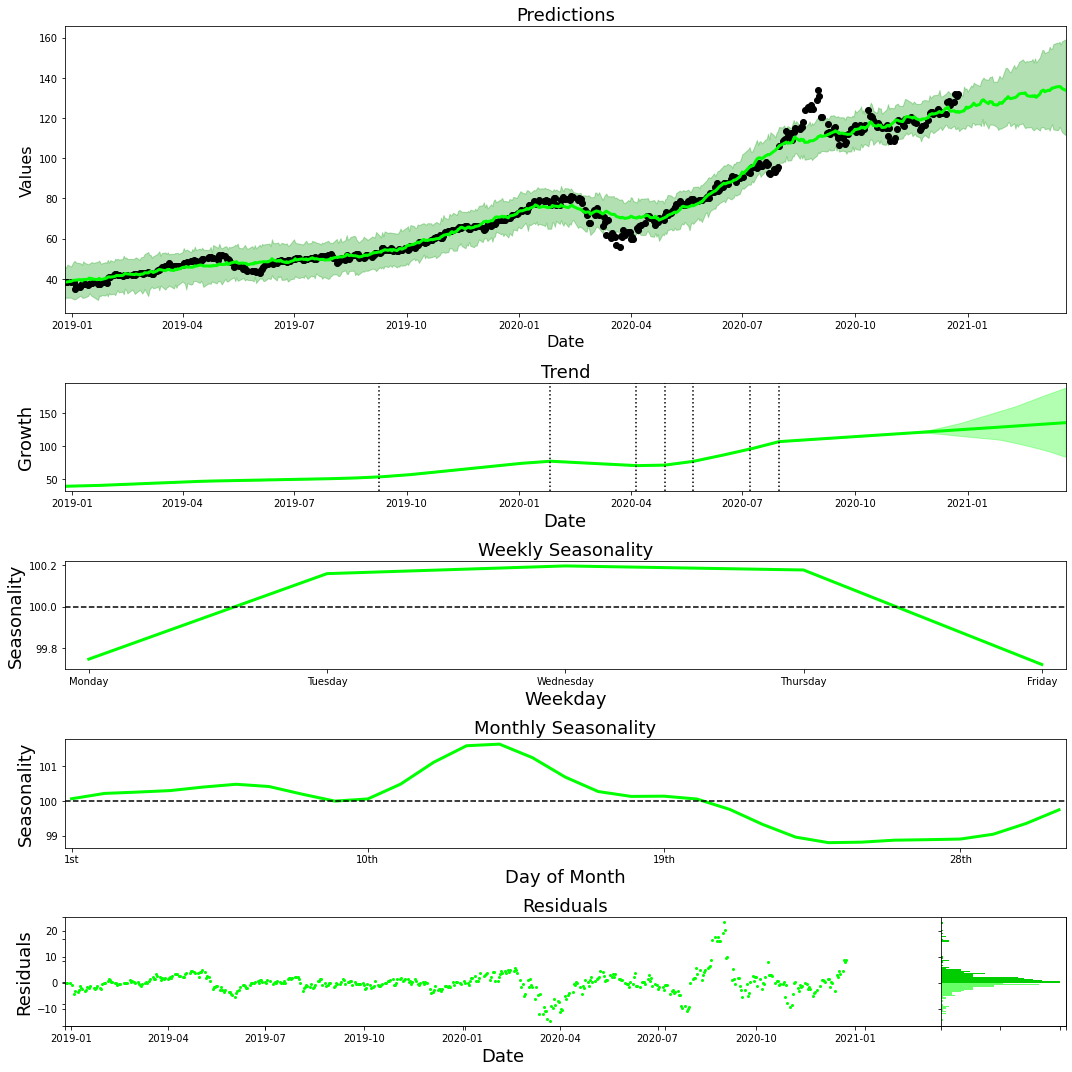

In [32]:
my_chronos.plot_components(predictions, figure_name="AAPL.png", changepoint_threshold=0.3);